In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fixed_point
import networkx as nx
from tqdm import tqdm

In [2]:
def find_component(node, connected_components):
    for i, component in enumerate(connected_components):
        if node in component:
            return i
    raise ValueError(f'Component for node {node} not found')

In [3]:
def giant_component(N, p, k, size=True):
    try:
        nodes_to_remove = random.sample(range(N), round(N * (1 - p)))
    except ValueError as e:
        print(f'{N = }, {p = }, {k = }')
        raise e

    Ga = nx.erdos_renyi_graph(N, k / (N - 1))
    Gb = nx.erdos_renyi_graph(N, k / (N - 1))
    # TODO: check Gb == Ga, transition point must be 1 / k.

    Ga.remove_nodes_from(nodes_to_remove)
    Gb.remove_nodes_from(nodes_to_remove)

    keep_going = True
    while keep_going:
        keep_going = False

        clusters_a = list(nx.connected_components(Ga))
        for edge in Gb.edges():
            if find_component(edge[0], clusters_a) != find_component(edge[1], clusters_a):
                keep_going = True
                Gb.remove_edge(*edge)

        clusters_b = list(nx.connected_components(Gb))
        for edge in Ga.edges():
            if find_component(edge[0], clusters_b) != find_component(edge[1], clusters_b):
                keep_going = True
                Ga.remove_edge(*edge)

    if size:
        try:
            return max(len(comp) for comp in nx.connected_components(Ga))
        except ValueError:
            return 0

    # Average degree is close to 1
    return 1 < np.mean(list(dict(Ga.degree).values()))

In [8]:
N = 100
nruns = 100
num_p = 20
k = 4

pvals = np.linspace(0, 1, num=num_p)
P = np.zeros(num_p, dtype=float)
sizes = np.zeros((num_p, nruns), dtype=int)
for i, p in enumerate(pvals):
    for j in range(nruns):
        size = giant_component(N, p, k)
        P[i] += size
        sizes[i, j] = size

    P[i] /= nruns * N

    np.save('P', P)

In [9]:
P

array([0.    , 0.0101, 0.0103, 0.0116, 0.0136, 0.0146, 0.0175, 0.0185,
       0.0213, 0.0432, 0.0719, 0.2172, 0.3349, 0.5093, 0.6121, 0.6967,
       0.7686, 0.8334, 0.9029, 0.9599])

In [10]:
P.shape

(20,)

In [11]:
def P_an(k, p):
    f = lambda S: np.array(p) * (1 - np.exp(-k * S))**2
    return fixed_point(f, .5)

C:\Users\kuzne\AppData\Local\Temp\ipykernel_10184\2061727304.py:15: RuntimeWarning: invalid value encountered in divide
  plt.plot(pvals, sizes.var(axis=1) / sizes.mean(axis=1), 'o-')


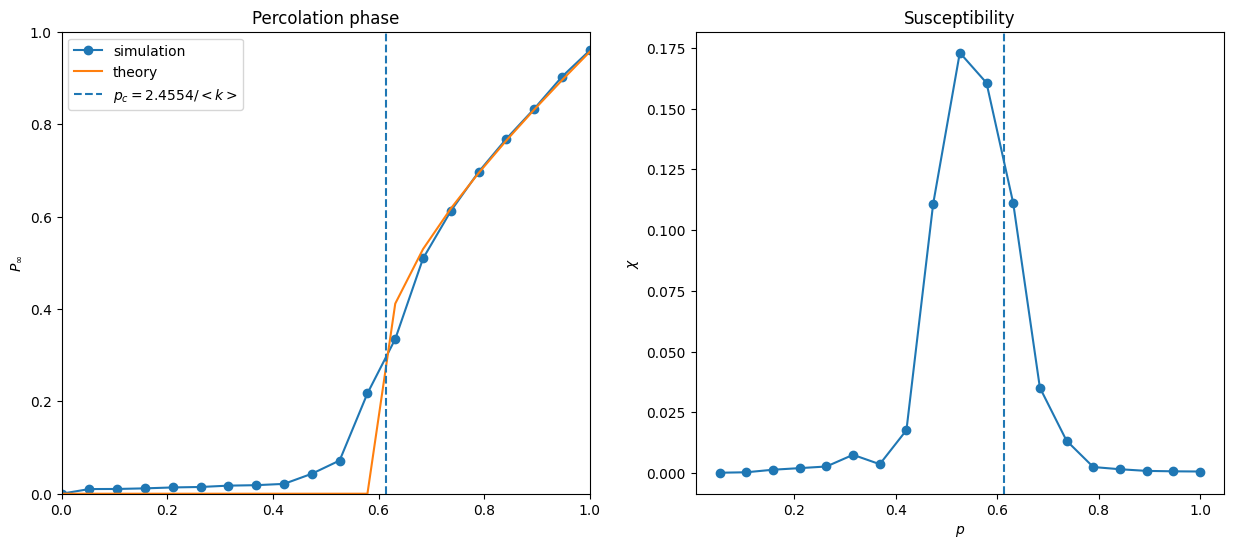

In [12]:
plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

plt.subplot(121)
plt.plot(pvals, P, '-o', label='simulation')
plt.plot(pvals, P_an(k, pvals), label='theory')
plt.ylabel('$P_{\infty}$')
plt.axvline(x=2.4554 / k, linestyle='--', label='$p_c = 2.4554 / <k>$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Percolation phase')
plt.legend()

sizes = np.array(sizes, dtype=float) / N
plt.subplot(122)
plt.plot(pvals, sizes.var(axis=1) / sizes.mean(axis=1), 'o-')
plt.axvline(x=2.4554 / k, linestyle='--')
plt.title('Susceptibility')
plt.xlabel('$p$')
plt.ylabel('$\chi$')

plt.savefig('plots/cascade.png')

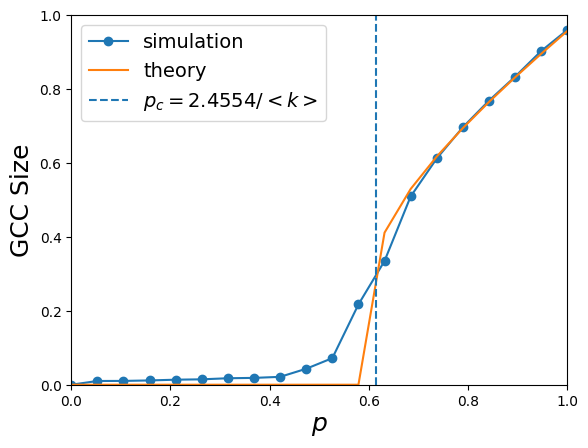

In [14]:
plt.plot(pvals, P, '-o', label='simulation')
plt.plot(pvals, P_an(k, pvals), label='theory')
plt.xlabel('$p$', fontdict={'size': 18})
plt.ylabel('GCC Size', fontdict={'size': 18})
plt.axvline(x=2.4554 / k, linestyle='--', label='$p_c = 2.4554 / <k>$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(fontsize=14)
plt.savefig('plots/cascade.png')